# Train SIMCLR Pipeline

## Set up

### Necessary Imports

In [1]:
pip install Pillow pytorch-lightning lightning-bolts lightly matplotlib wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import torch
import torchvision
import numpy as np
import wandb
import PIL
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models import alexnet
import pytorch_lightning as pl
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)
from pl_bolts.optimizers import LARS
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from pytorch_lightning.loggers import WandbLogger
import lightly
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss
from matplotlib import pyplot as plt

/opt/conda/envs/python37/lib/python3.7/site-packages/lightly/cli/train_cli.py:145: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")
/opt/conda/envs/python37/lib/python3.7/site-packages/lightly/cli/embed_cli.py:97: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/opt/conda/envs/python37/lib/python3.7/site-packages/lightly/cli/upload_cli.py:167: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/opt/conda/envs/python37/lib/python3.7/site-packages/lightly/cli/lightly_cli.py:70: UserWarning: 
The version_base parameter

### Instatiate GPU and configure logger

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb_logger = WandbLogger(project="NIS")
device

device(type='cuda')

## Test Augmentations

In [4]:
example_dataset = lightly.data.LightlyDataset(f'../datasets/DomainNet/real',transform = torchvision.transforms.Resize((64,64)))
test_collate_fn = lightly.data.SimCLRCollateFunction(input_size=64,gaussian_blur=0.0,cj_prob=0)
dataloader_simclr = DataLoader(
                        example_dataset,
                        batch_size=5,
                        shuffle=False,
                        collate_fn=test_collate_fn,
                        drop_last=True,
                        num_workers=8,
                        pin_memory=False
                    )

### Visualize Augmentations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

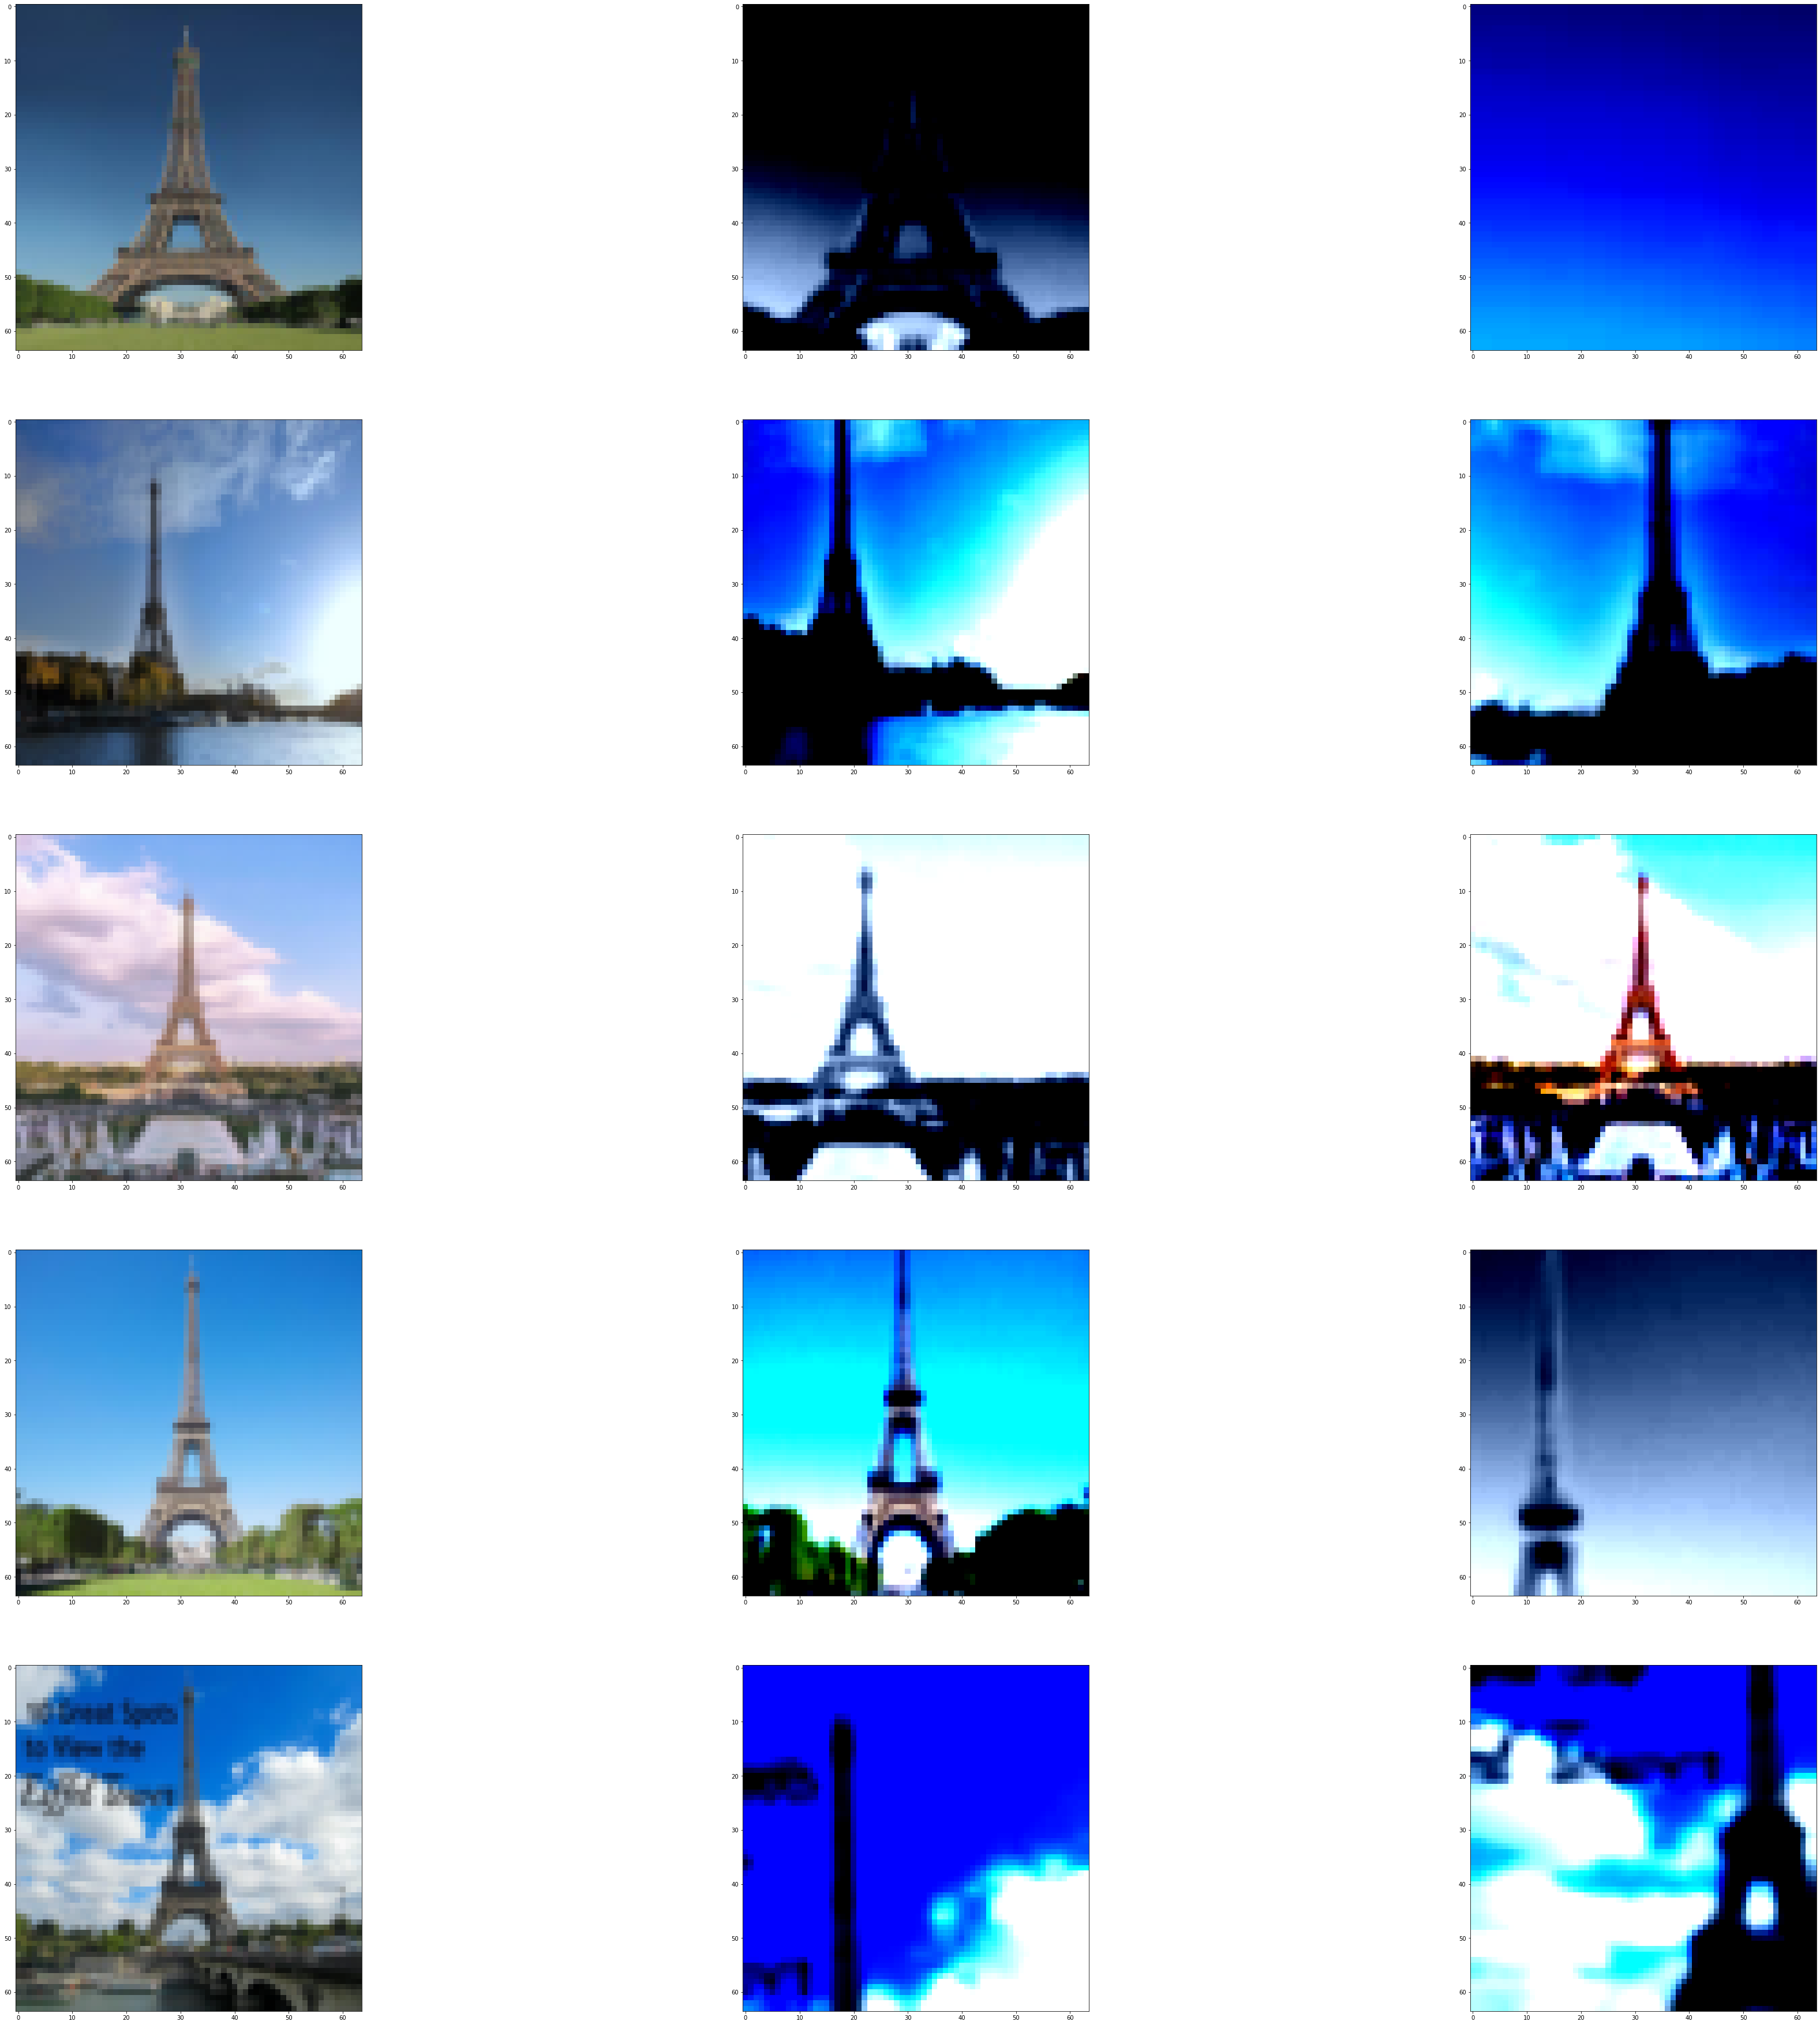

In [5]:
iterator = iter(dataloader_simclr)
batch,labels,files = next(iterator)
aug1 = batch[0]
aug2 = batch[1]
fig,ax = plt.subplots(5,3,figsize=(64,64),facecolor='w')
for i in range(5):
    ax[i,0].imshow(example_dataset[i][0])
for i in range(5):
    ax[i,1].imshow(aug1[i].permute(1,2,0))
for i in range(5):
    ax[i,2].imshow(aug2[i].permute(1,2,0))

## Train AlexNet-based SIMCLR Model

### Design Model

In [6]:
class SimCLRModel(pl.LightningModule):
    def __init__(self, backbone = alexnet(pretrained=False),
                 dataset_path = '../datasets/DomainNet/real', 
                 transform = torchvision.transforms.Resize((64,64)), 
                 batch_size = 512,
                 temp = 0.1, 
                 learning_rate = 1e-2,  
                 momentum = 0.9, 
                 weight_decay = 1e-6):
        super().__init__()
        hidden_dim = 9216
        self.save_hyperparameters()
        self.backbone = torch.nn.Sequential(*list(backbone.children())[:-1])
        self.dataset_path = dataset_path
        self.transform = transform
        self.batch_size = batch_size
        self.temp = temp
        self.lr = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)
        self.criterion = NTXentLoss(temperature=temp)

    def forward(self, x):
        h=self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = LARS(params=self.parameters(),lr=self.lr,momentum=self.momentum,weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=30, threshold=0.2, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        return {
        "optimizer": optim,
        "lr_scheduler": {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss_ssl",
            "frequency": 30
            # If "monitor" references validation metrics, then "frequency" should be set to a
            # multiple of "trainer.check_val_every_n_epoch".
        },
    }
    
    def train_dataloader(self):
        collate_fn = lightly.data.SimCLRCollateFunction(input_size=64,gaussian_blur=0.0,cj_prob = 0)#normalize={'mean':[0, 0, 0],'std':[1, 1, 1]})
        return DataLoader(
                        lightly.data.LightlyDataset(self.dataset_path,transform = torchvision.transforms.Resize((64,64))), 
                        batch_size=self.batch_size,
                        shuffle=True,
                        collate_fn=collate_fn,
                        drop_last=True,
                        num_workers=8,
                        pin_memory=False
                    )

### Create loggers and callbacks

In [7]:
logger = WandbLogger(name='simclr_domainnet', id='real64', project = 'rep_data', log_model='all')
checkpoint = pl.callbacks.ModelCheckpoint(monitor='train_loss_ssl',mode='min',save_last=True, every_n_epochs = 50)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

### Start Training

In [ ]:
model = SimCLRModel()
logger.watch(model,log_graph=False)
trainer = pl.Trainer(gpus=1,strategy="dp",max_epochs=200, progress_bar_refresh_rate=100, logger=logger, callbacks=[checkpoint,lr_monitor])
trainer.fit(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aaprasad (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/opt/conda/envs/python37/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 2.5 M 
1 | transform       | Resize               | 0     
2 | projection_head | SimCLRProjectionHead | 86.1 M
3 | cri

Training: 0it [00:00, ?it/s]

In [ ]:
wandb.finish()